<b><font size=5><center>Оценка результатов А/В теста, связанного с внедрением улучшенной рекомендательной системы. Финальный проект.</center></font></b>

### Цель исследования

Изучить результаты тестирования изменений, связанных с внедрением улучшенной рекомендательной системы.
Для этого мы проведем:
- Оценка корректности проведения теста;
- Анализ результатов теста

Чтобы оценить корректность проведения теста, проверим:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Описание проекта

Мы получили данные проведения А/В теста, проверили их на аномалии, проработали типы данных. Также мы проверили корректность проведения теста и почистили данные. Построили графики распределения и воронку событий с конверсией. Провели оценку результатов теста с помощью z-критерия. 

### Получение, проверка и подготовка данных

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
participants = pd.read_csv(r"C:\Users\mi\Downloads\final_ab_participants.csv")
new_users = pd.read_csv(r"C:\Users\mi\Downloads\final_ab_new_users.csv")
marketing_events = pd.read_csv(r"C:\Users\mi\Downloads\ab_project_marketing_events.csv")
data = pd.read_csv(r"C:\Users\mi\Downloads\final_ab_events.csv")

    
display(data.head())
display(marketing_events.head())
display(new_users.head())
participants.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [3]:
data.info()
marketing_events.info()
new_users.info()
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id    

Сразу разберемся со временем

In [4]:
data['event_dt'] = pd.to_datetime(data['event_dt']).dt.date #timestamp тоже приведем в формат даты для удобства, т.к. время в дальнейшем анализе мы не используем
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt']).dt.date
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt']).dt.date
new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date

Пропуски есть только в колонке `details` датасета `data` потому, что в ней отображены только суммы покупок - конкретного события из столбца `event_name`. Заменим их заглушкой "0" для упрощения дальнейших подсчетов.

In [5]:
data['details'].fillna(0, inplace=True)

In [6]:
print(data.duplicated().sum())
print(marketing_events.duplicated().sum())
print(new_users.duplicated().sum())
participants.duplicated().sum()

2
0
0


0

Явных дубликатов нет

### Оценка корректности проведения теста

Объединим датасеты для удобства проверок и работы

In [7]:
all_data = data.merge(new_users, on='user_id', how='inner')
all_data = all_data.merge(participants, on='user_id', how='inner')
print(len(all_data))
all_data.head()

106625


,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,96F27A054B191457,2020-12-07,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
1,96F27A054B191457,2020-12-08,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
2,96F27A054B191457,2020-12-09,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
3,96F27A054B191457,2020-12-26,purchase,9.99,2020-12-07,EU,iPhone,B,interface_eu_test
4,96F27A054B191457,2020-12-07,product_page,0.00,2020-12-07,EU,iPhone,B,interface_eu_test


Очистим сначала данные нашего теста от других тестов

In [8]:
all_data['ab_test'].value_counts()
all_data = all_data.query('ab_test == "recommender_system_test"')
print(len(all_data))

24698


Проверим, не задвоились ли участники групп теста

In [9]:
duplicated_users = all_data.groupby('user_id').agg({'group': ['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_names']
duplicated_users = duplicated_users.query('groups > 1')
display(duplicated_users.head())

,groups,group_names
user_id,,


Пользователей, попавших в обе группы нашего теста нет.

In [10]:
all_data.groupby('group').agg({'user_id': 'nunique'}) # проверка количества людей в группах

,user_id
group,
A,2747
B,928


Проверим время тестов

In [11]:
print(all_data['first_date'].min())  # даты начала и окончания привлечения новых пользователей
print(all_data['first_date'].max())

2020-12-07
2020-12-21


In [12]:
print(all_data['event_dt'].min())  # даты начала и окончания теста
print(all_data['event_dt'].max()) 

2020-12-07
2020-12-30


Судя по выводу в датасете с действиями данные заканчиваются 30.12.2020 года, вместо запланированного 04.01.2021. Возможно, по каким-то причинам тест остановили раньше. Посчитаем lifetime

In [13]:
print('Количество действий:', len(all_data))
print('Количество уникальных пользователей:', all_data['user_id'].nunique())

Количество действий: 24698
Количество уникальных пользователей: 3675


In [14]:
all_data['lifetime'] = (all_data['event_dt'] - all_data['first_date']).dt.days

all_data.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,lifetime
12,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,0
13,831887FE7F2D6CBA,2020-12-09,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2
14,831887FE7F2D6CBA,2020-12-07,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,0
15,831887FE7F2D6CBA,2020-12-08,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,1
16,831887FE7F2D6CBA,2020-12-09,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,2


In [15]:
all_data = all_data.query('lifetime <= 14') # отсеим по лайфтайму в 14 дней по ТЗ

In [16]:
print('Количество действий после фильтрации по лайфтайму:', len(all_data))
print('Количество уникальных пользователей после фильтрации по лайфтайму:', all_data['user_id'].nunique())

Количество действий после фильтрации по лайфтайму: 24070
Количество уникальных пользователей после фильтрации по лайфтайму: 3675


Еще раз проверим границы дат после фильтрации

In [17]:
print(all_data['first_date'].min())  # даты начала и окончания привлечения новых пользователей
print(all_data['first_date'].max())

2020-12-07
2020-12-21


In [18]:
print(all_data['event_dt'].min())  # даты начала и окончания теста
print(all_data['event_dt'].max()) 

2020-12-07
2020-12-29


Таким образом наш тест проводился с 07.12.2020 по 29.12.2020. Здесь наблюдается несоответствие ТЗ.

Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями.

In [19]:
marketing_events[(marketing_events['start_dt'] <= dt.date(2020, 12, 29)) 
                 & (marketing_events['finish_dt'] >= dt.date(2020, 12, 7))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


На время проведения теста попадает рождество и преддверие нового года в Европе и Северной Америке. Чистить пользователей, пришедших во время маркетинговых мероприятий смысла нет - они в любом случае скорее всего попали в обе группы, так что существенного влияния именно на результаты теста оказать не должны. При расчете маркетинговых метрик будем иметь в виду факт наличия дополнительного стимула покупок извне.

Проверим данные на соответствие пункту ТЗ - `аудитория: 15% новых пользователей из региона EU`

In [20]:
all_data.query('region == "EU"')['user_id'].nunique() #количество пользователей из Европы в тесте

3481

In [21]:
all_data.query('region == "EU"')['user_id'].nunique() / new_users.query('region == "EU"')['user_id'].nunique()

0.07523233196455587

In [22]:
print('Финальное количество пользователей в тесте:', all_data['user_id'].nunique())
print('Финальное количество логов в тесте:', len(all_data))
all_data.head()

Финальное количество пользователей в тесте: 3675
Финальное количество логов в тесте: 24070


,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,lifetime
12,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test,0
13,831887FE7F2D6CBA,2020-12-09,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test,2
14,831887FE7F2D6CBA,2020-12-07,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,0
15,831887FE7F2D6CBA,2020-12-08,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,1
16,831887FE7F2D6CBA,2020-12-09,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test,2


#### Вывод

Данные по многим параметрам не соответствуют ТЗ:

- Дата остановки теста - тест завершили на 5 дней раньше;
- Количество участников теста почти вдвое меньше ожидаемых 6000;
- Ожидаемая аудитория - 15% новых пользователей из региона EU, составляет всего 7,5%;
- В данных были участники других тестов, а во время проведения теста также проводилось маркетинговое мероприятие, которое может сказаться на метриках;
- Пользователи по группам теста распределены очень неравномерно, даже после очистки - контрольная группа сильно больше тестовой (75/25%). 
    
Данные по необходимости очищены и приведены в нужный вид. 

### Исследовательский анализ данных

Посмотрим, одинаково ли распределены в выборках количество событий на пользователя

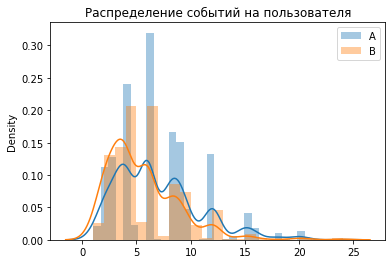

In [23]:
for group in all_data['group'].unique():
    current = all_data.query('group == @group')
    sns.distplot(current.groupby('user_id').agg({'event_name': 'count'}), label = group)
    plt.title('Распределение событий на пользователя')
    plt.legend() 
plt.show()

У группы А распределение больше похоже на нормальное. У группы В распределение асимметричное, смещенное влево, с выбросами

Посмотрим, как число событий в выборках распределено по дням

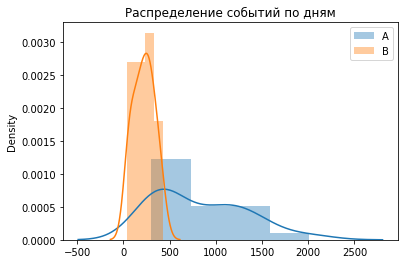

In [24]:
for group in all_data['group'].unique():
    current = all_data.query('group == @group')
    sns.distplot(current.groupby('event_dt').agg({'event_name': 'count'}), label = group)
    plt.title('Распределение событий по дням')
    plt.legend() 
plt.show()

Распределение по дням группы А - плавное и нормальное. У группы В набллюдается разкий пик около 0. Это может быть связано с неравномерным распределением количества пользователей по группам - в группу В попало гораздо меньше людей. 

Посмотрим, как меняется конверсия в воронке в выборках на разных этапах


In [25]:
funnel = all_data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A', ascending=False).reset_index()
funnel

group,event_name,A,B
0,login,2747,927
1,product_page,1780,523
2,purchase,872,256
3,product_cart,824,255


In [26]:
for i in range(len(funnel)):
    funnel.loc[i, 'convA'] = round(funnel.iloc[i, 1] / funnel.iloc[0, 1] * 100, 1)
    funnel.loc[i, 'convB'] = round(funnel.iloc[i, 2] / funnel.iloc[0, 2] * 100, 1)
funnel

group,event_name,A,B,convA,convB
0,login,2747,927,100.0,100.0
1,product_page,1780,523,64.8,56.4
2,purchase,872,256,31.7,27.6
3,product_cart,824,255,30.0,27.5


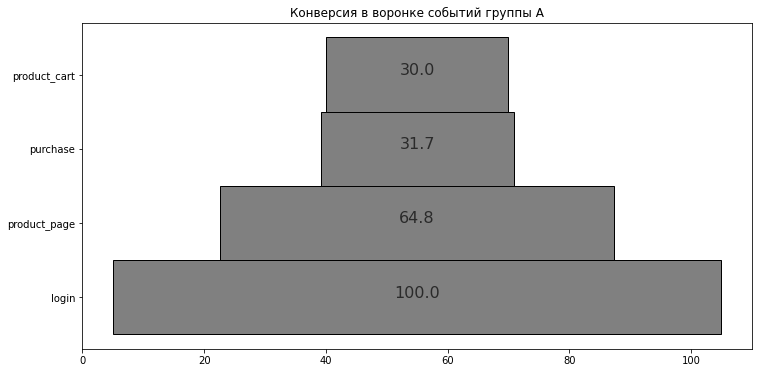

In [27]:
x_max = 110
x_min = 0
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(funnel['convA']):
    left = (x_max - val)/2
    plt.barh(funnel['event_name'][idx], funnel['convA'][idx], left = left, color='grey', height=1, edgecolor='black')
    # value
    plt.text(55, funnel['event_name'][idx], funnel['convA'][idx], ha='center',
             fontsize=16, color='#2A2A2A')
plt.xlim(x_min, x_max)
plt.title('Конверсия в воронке событий группы А');

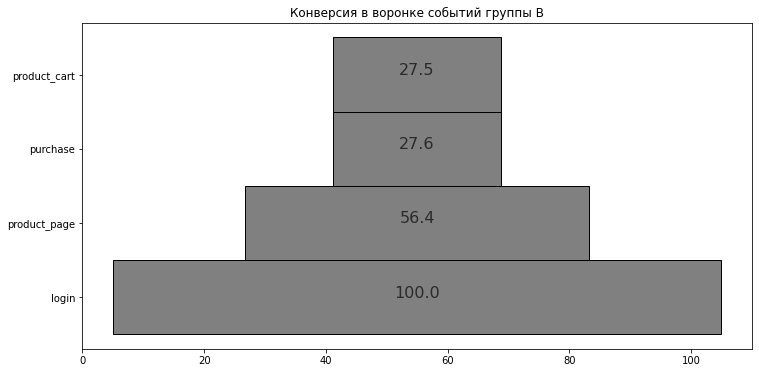

In [28]:
x_max = 110
x_min = 0
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(funnel['convB']):
    left = (x_max - val)/2
    plt.barh(funnel['event_name'][idx], funnel['convB'][idx], left = left, color='grey', height=1, edgecolor='black')
    # value
    plt.text(55, funnel['event_name'][idx], funnel['convB'][idx], ha='center',
             fontsize=16, color='#2A2A2A')
plt.xlim(x_min, x_max)
plt.title('Конверсия в воронке событий группы B');

В воронках событий различия между группами очень малы: в группе А 32 % пользователей переходят к покупкам, а в группе В - 28%.

#### Вывод

Прежде чем приступать к A/B-тестированию, нужно принять во внимание тот факт, что распределение пользователей по группам перекошено, это может сделать выборку нерепрезентативной и дать неправильные результаты при проверке гипотез.
Также надо принять во внимание, что на время проведения теста выпало маркетинговое мероприятие, посвященное рождеству и новому году, что также может влиять на метрики. Предполагается, что это мероприятие одинаково влияет на обе группы.
В целом, по показателям распределений и воронки событий данные обеих групп имеют одинаковые паттерны. Только распределение событий по времени в группе В немного отличается и имеет довольно сжатый график распределения по времени. Спишем это на малое количество пользователей в группе В.

### Оценка результатов А/В тестирования

Проверим статистическую разницу долей z-критерием. Критический уровень значимости установим на уровне 0.006 с учетом поправки Бонферрони на 8 последующих проверок.

    H0: доли уникальных посетителей, побывавших на этапе воронки, не имеют статистически значимых различий
    Н1: между долями уникальных посетителей, побывавших на этапе воронки, есть статистически значимые различия

In [29]:
def check_hypothesis(successes1, successes2, trials1, trials2):   # функция для проверки статистической значимости различий в конверсиях
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

trials = all_data.groupby('group').agg({'user_id': 'nunique'})
display(trials)
funnel_by_groups = all_data.pivot_table(index='event_name', columns = 'group', values = 'user_id', aggfunc='nunique').sort_values(by='A', ascending=False)
display(funnel_by_groups)

,user_id
group,
A,2747
B,928


group,A,B
event_name,,
login,2747,927
product_page,1780,523
purchase,872,256
product_cart,824,255


In [30]:
for event in all_data['event_name'].unique():
    funnel_by_groups.loc[event, 'p_value'] = check_hypothesis(funnel_by_groups.loc[event, 'A'], funnel_by_groups.loc[event, 'B'],
                                       trials.loc['A'].values[0],  trials.loc['B'].values[0])

funnel_by_groups

group,A,B,p_value
event_name,,,
login,2747,927,0.085299
product_page,1780,523,0.000004
purchase,872,256,0.017592
product_cart,824,255,0.145348


Нулевую гипотезу подтвердить не получилось - по итогу проверки одно из значений p-value не превысило критический уровень (даже с поправкой). Таким образом можно сказать, что между долями уникальных посетителей, побывавших на этапе воронки, есть статистически значимые различия

### Общий вывод

Мы получили данные проведения А/В теста, проверили их на аномалии, проработали типы данных. Также мы проверили корректность проведения теста и почистили данные. Построили графики распределения и воронку событий с конверсией. Провели оценку результатов теста с помощью z-критерия.

Изучение данных для теста и результатов теста показало, что данные теста по многим параметрам не соответствуют ТЗ:

- Дата остановки теста - тест завершили на 5 дней раньше;
- Количество участников теста почти вдвое меньше ожидаемых 6000;
- Ожидаемая аудитория - 15% новых пользователей из региона EU, составляет всего 7,5%;
- В данных были участники других тестов, а во время проведения теста также проводилось маркетинговое мероприятие, которое может сказаться на метриках;
- Пользователи по группам теста распределены очень неравномерно, даже после очистки - контрольная группа сильно больше тестовой (75/25%). 
    
Мы провели тест на статистическую разницу долей z-критерием и нулевая гипотеза была опровергнута. 
Все вышеприведенное показывает, что тест был проведен неверно - данные перекошены и не соответствуют ТЗ, и лучше провести тест еще раз, так как его результаты нерепрезентативны.